In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tqdm import tqdm

tf.compat.v1.enable_v2_behavior()

from curiosity import m_passthrough_action

In [3]:
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_schedule as pruning_sched
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_wrapper
from tensorflow_model_optimization.python.core.sparsity.keras import prune
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_callbacks

In [4]:
def matrix_dist(A, B):
    return np.linalg.norm((A - B).flatten(), ord=1)

In [5]:
# "model of the environment"
A = np.array([
    [1,0,1,0], # state and action, gives s_1
    [0,1,0,1],
])

# transform for the state
Q1 = np.random.randn(2, 2)

# transform for state+action
Q = np.eye(4)
Q[:2, :2] = Q1

# number of data pts
N = 1000

# states
xs = np.random.randn(4, N)

# next states
ys = A @ xs

xs_e = Q @ xs
ys_e = Q1 @ ys

# states
xs = xs.T
ys = ys.T

# observations
xs_e = xs_e.T
ys_e = ys_e.T

In [6]:
# checking that the model works correctly
assert np.allclose(A @ (np.linalg.inv(Q) @ xs_e[0]), ys[0])
assert np.allclose(xs_e[0][2:], xs[0][2:])

1000/1000 [==============================] - 0s 40us/sample - loss: 0.0058
0.005777317818254232
[<tf.Variable 'sequential/dense/kernel:0' shape=(4, 2) dtype=float32, numpy=
array([[ 9.9999982e-01, -3.4779450e-03],
       [-1.0212220e-08,  9.0061408e-01],
       [ 9.9999934e-01, -2.4173937e-03],
       [-4.0995943e-08,  9.6122342e-01]], dtype=float32)>, <tf.Variable 'sequential/dense/bias:0' shape=(2,) dtype=float32, numpy=array([4.3519279e-08, 2.9487954e-03], dtype=float32)>]
0.14405871809865012


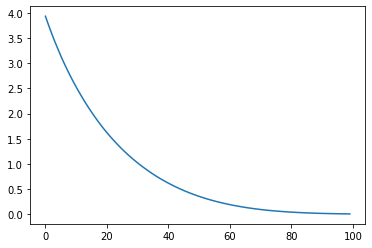

In [7]:
# checking that data is correctly generated
m = tf.keras.Sequential([tf.keras.layers.Dense(2)])
m.compile('adam', 'mse')
h = m.fit(xs, ys, epochs=100, verbose=0)
plt.plot(h.history['loss'])
print(m.evaluate(xs, ys))
print(m.weights)
print(matrix_dist(m.weights[0].numpy().T, A))

In [8]:
l1coeff = 2e-5
l2coeff = 0
sparsity = 0.3

pruning_params = {
        #'pruning_schedule': pruning_sched.ConstantSparsity(sparsity, 0),
        'pruning_schedule': pruning_sched.PolynomialDecay(0, 0.3, 0, 100),
        'block_size': (1, 1),
        'block_pooling_type': 'AVG'
    }

def get_results(l1coeff):

    decoder = tf.keras.Sequential([
        tf.keras.Input(shape=(2,)),
        tf.keras.layers.Dense(2, activation=None, use_bias=False, #kernel_regularizer=tf.keras.regularizers.l2(l2coeff),
                             #kernel_initializer='random_normal',
                             #kernel_constraint=tf.keras.constraints.UnitNorm()
                             kernel_constraint=tf.keras.constraints.MinMaxNorm(0.5, 1.5)
                             ),
    ])

    # maps observations to features
    model = tf.keras.Sequential([
        m_passthrough_action(decoder, 2, 2),
        tf.keras.Input(shape=(4,)),
        #prune.prune_low_magnitude(
            tf.keras.layers.Dense(2, activation=None, use_bias=False, kernel_regularizer=tf.keras.regularizers.l1(l1coeff),
                                 #kernel_initializer='random_normal'
                                 ),
        #**pruning_params)
    ])

    def loss_with_decoder(y_true, y_pred):
        return tf.reduce_mean(tf.abs(y_pred - decoder(y_true)))

    model.compile(optimizer='adam', loss=loss_with_decoder)

    losses = []
    distances = []
    for _ in tqdm(range(10)):
        h = model.fit(xs_e, ys_e, epochs=10, batch_size=16, verbose=0)#, callbacks=[pruning_callbacks.UpdatePruningStep()])
        loss = model.evaluate(xs_e, ys_e, verbose=0)
        DE = decoder.weights[0].numpy().T @ Q1
        #DE = DE / DE[0, 0]
        #dist = matrix_dist(DE, np.eye(2)) # it can swap them as well...
        #l1, l2 = np.linalg.eig(DE.T @ DE)[0]
        DE = DE / np.max(DE, axis=0)
        dist = min(matrix_dist(DE, np.eye(2)), matrix_dist(DE, np.eye(2)[:,[1,0]]))
        #dist = np.abs(np.abs(l1) - np.abs(l2))
        losses.append(loss)
        distances.append(dist)
    return losses, distances, model

In [9]:
l1regs = np.logspace(-8, 2, 20)
repetitions = 5

100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


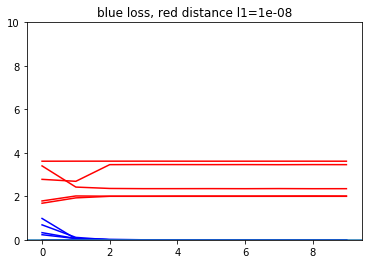

100%|██████████| 10/10 [00:06<00:00,  1.46it/s]


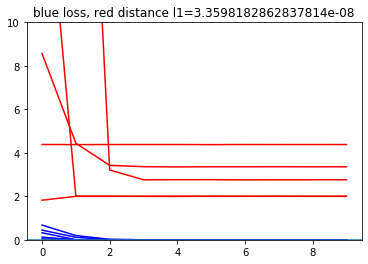

100%|██████████| 10/10 [00:06<00:00,  1.45it/s]


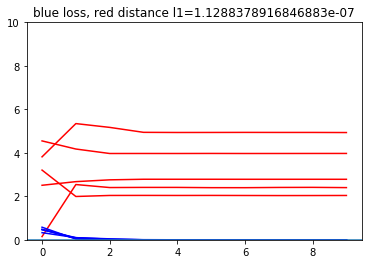

100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


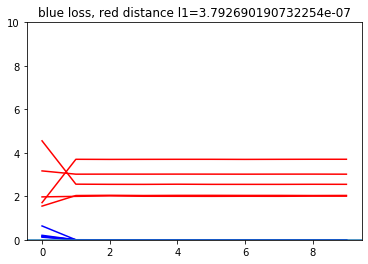

100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


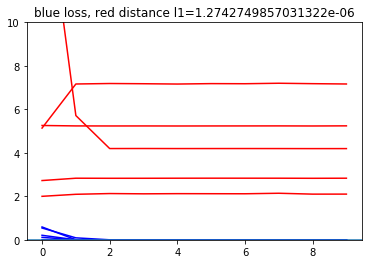

100%|██████████| 10/10 [00:07<00:00,  1.42it/s]


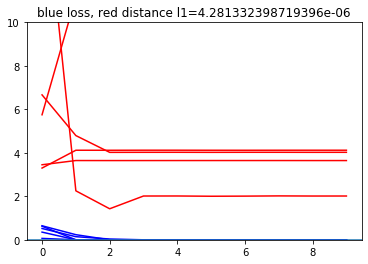

100%|██████████| 10/10 [00:07<00:00,  1.31it/s]


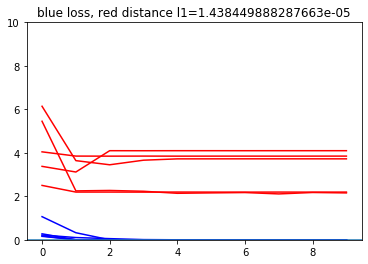

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
for l1 in l1regs:
    plt.figure()
    plt.title("blue loss, red distance l1=%s" % str(l1))
    for _ in range(repetitions):
        losses, distances, _ = get_results(l1)
        plt.plot(losses, color='blue')
        plt.plot(distances, color='red')
    plt.axhline(0)
    plt.ylim(0, 10)
    plt.show()

In [ ]:
losses, distances, model = get_results(1e-3)
plt.plot(losses, color='blue')
plt.plot(distances, color='red')

Problem: the example doesn't work
Anothe problem: $|\lambda_1|\approx|\lambda_2|$ is only a necessary condition but not sufficient...

And it's also not necessary -- can have (1, 2) and then it's not about this at all...

In [ ]:
model.weights

How to regularize foe the number of non-zero elements? Use SparseSep instead of l1 https://arxiv.org/pdf/1701.06967.pdf

How to evaluate the transform $DE=?$